# Fourth Task: Prediction

### Import of the needed libraries and the dataset

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import pydotplus 
from IPython.display import Image  
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

cyclists = pd.read_csv('./dataset/cyclists_trasformed.csv')
races = pd.read_csv('./dataset/races_trasformed.csv')

# Data Preparation

Before employing the learning algorithms, we need to perform a few adjustments to our data. 

Firstly, it is necessary to merge the two dataset and delete not useful columns for the purpose.

Then, we will add an attribute for specifying if a certain cyclist was in the first 20 position of a race or not. 

We delete:

• *name* (coming from cyclist), since it is a repetition for *_url* in cyclist

• *name* (coming from races), since it is a repetition for *_url* in races

• *weight* and *height* (coming from cyclist), since these characteristics are combined in the *bmi* feature we created 

• *avg_position* and *avg_delta* (coming from cyclist), since it is better to consider more precise columns like *position* (see next) and *delta* from races

• *position* (coming from races) since we consider only the first 20 we will get from the new column 

• *birth_year* (coming from cyclist) because it's redundant having *cyclist_age* from races

• *cyclist_team* (coming from races) since we consider single cyclists

• *date* (coming from races) whose format is: "YYYY-MM-DD HH-MM-SS". From it, we can extract the information we need: we exclude the "HH-MM-SS" and the "MM-DD" part because we can easily group races based on the *season* of the year (attribute that we already have). At the end, we only care about the year for splitting the races for the training set.

We add:

• *top_20*, having value =1 if the corresponding cyclist was in between these positions or, on the opposite, =0.

**NB**: we drop *position* after creating the column *top_20*, since it is needed to fill the new one correctly.

In [ ]:
#Merge
data_merged = pd.merge(races, cyclists, left_on='cyclist', right_on='_url', how='outer', indicator=True)

#Filter non-corresponding rows: these cyclists never participate to a competition, so we don't consider them either for the prediction
mismatched = data_merged[data_merged['_merge'] != 'both']
print(f"Number of mismatched entries: {len(mismatched)}")
print(mismatched)

#Drop 
data_merged = data_merged[data_merged['_merge'] == 'both']

#Drop the '_merge' column as it's no longer needed
data_merged.drop('_merge', axis=1, inplace=True)


Following the specification, we create the new attribute *top_20* where the value is '1' if in the row the attribute *position* ranges from 0 to 19, '0' otherwise. 

As stated before, we drop *position* since is useless from now on and modify *date* so that it contains only the year. 


In [ ]:
# Rename '_url_x' in 'race_url' and '_url_y' in 'cyclist_url'
data_merged.rename(columns={'_url_x': 'race_url', '_url_y':'cyclist_url'}, inplace=True)

#Delete useless columns we cited, except position
data_merged = data_merged.drop(columns=['name_x', 'name_y', 'cyclist', 'weight', 'height', 'birth_year', 'avg_position', 'avg_delta', 'cyclist_team'])

#Create 'top_20'
data_merged['top_20'] = (data_merged['position'] < 20).astype(int)

#Drop position 
data_merged = data_merged.drop(columns=['position']) 

data_merged.head()

In [ ]:
data_merged.info()

The learning algorithms require the categorical data to be transformed into numerical ones.

In order to do this, we define the following function that assign a number for each different value inside the 
attribute starting from 1 and substitutes the categorical.  

We cast the boolean values for *is_tarmac* to int. 

At the end, we are ready to define our 'train_set' and 'test_set' variables based on the year we get from *date*:

- Training set: needed to train models.
- Test set: need to test the model on never-seen data.

In [119]:
#Function to discretize the variables
#Input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #Get the unique variable's values
        var = sorted(dataset[variable].unique())
        #Generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))
        dataset[variable] = dataset[variable].map(mapping).astype(int)
    return dataset

In [120]:
#Attribute to transform
categorical_variables = ['race_url', 'season', 'cyclist_url', 'nationality', 'continent']
data_merged = discretize_data(data_merged, categorical_variables)

#Other casting
data_merged['is_tarmac'] = data_merged['is_tarmac'].astype(int)
data_merged['date'] = pd.DatetimeIndex(data_merged['date']).year

#Training set
train_data = data_merged[data_merged['date'] < 2022]
#Test set
test_data = data_merged[data_merged['date'] >= 2022]


In [ ]:
train_data.head()

In [ ]:
train_data.info()

In [ ]:
test_data.head()

In [ ]:
test_data.info()

For our machine learning purpose, the dataset has to be divided into two parts:

- Features (x): The input data containing the information needed by the model to make predictions (every attribute except *top_20*)
- Target (y): The output data you want the model to predict (precisely *top_20*).

So, we create two variables for both *train_data* and *test_data*.

In [125]:
#Feature(x) and target(y) for training
x_train = train_data.drop(columns=['top_20'])
y_train = train_data['top_20']

#Feature(x) and target(y) for testing
x_test = test_data.drop(columns=['top_20'])
y_test = test_data['top_20']


# Learning Algorithms

The models we choose can be divided in different categories:

1) Tree-Based Models (Decision Tree, Random Forest)

2) AdaBoost

3) Naïve Bayes

4) K-Nearest Neighbors (KNN)

5) Neural Network


`NB`: We tried to implement XGBoost, Rule-Based and SVM but after 15 minutes the methods were still running. 

In [126]:
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['Non-Top 20', 'Top 20']))

## Tree-Based Models (Decision Tree, Random Forest, AdaBoost)


### Decision Tree Model

In [127]:
#Creating and configuring the Decision Tree
dt = tree.DecisionTreeClassifier(
    criterion='gini',               #Use the Gini index to evaluate the purity of splits
    splitter='best',                #Splits the nodes by choosing the best split
    class_weight='balanced',         
    max_depth=5,                    #Limit tree depth to 5 levels
    min_samples_split=3,            #A node must have at least 3 samples to be split
    min_samples_leaf=4,             #Each leaf must contain at least 4 examples
    random_state=42                 #Ensures repeatability of results
)

#Train the model
dt = dt.fit(x_train, y_train)

Visualizing the actual Decision Tree obtained: 

In [128]:
#To visualize the Decision Tree, you must intsall GraphViz
#MacOs: brew install graphviz
#Linux: sudo apt-get install graphviz
#Windows: Install from here https://graphviz.org/download/ 
#and add the following enviroment variable (the path can change)
#import os
#os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38/bin/'

In [ ]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=list(x_train.columns),  
                                class_names=['Non-Top 20', 'Top 20'],  
                                filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())


In [ ]:
#Prediction over test dataset employing Decision Tree
test_pred_dt = dt.predict(x_test)    

#Compute the performance of the model
report_scores(y_test, test_pred_dt)

How to read the result:
- **Non-Top 20**: 
    - Precision: 0.95 - Of all the predictions that the model classified as ‘Non-Top 20’, 95% were correct.
    - Recall: 0.75: 75% of the riders actually ‘Non-Top 20’ were correctly identified by the model.
    - F1-Score: 0.84 - Represents the balance between precision and recall, and is very high for this class, indicating that the model is excellent at correctly distinguishing ‘Non-Top 20’ cyclists.
    - Support: 30.466 - Indicates the total number of true samples belonging to the ‘Non-Top 20’ class.
- **Top 20**: 
    - Precision: 0.33 - Of all predictions classified as ‘Top 20’, only 33% are correct. This indicates that the model tends to include false positives.
    - Recall: 0.77 - 77% of the cyclists actually in the ‘Top 20’ were recognised correctly. 
    - F1-Score: 0.46 - Being the balance between precision and recall, the mid-low value suggests that the model has difficulty with the ‘Top 20’ class.
    - Support: 4.940 - Indicates the total number of true samples belonging to the ‘Top 20’ class.
- **Accuracy** 
    - Accuracy: 0.75 - Percentage of correct predictions out of the total data. Although the value is high, it is influenced by the strong dominance of the Non-Top 20 class (majority class).
- **Macro Average**
    - Precision: 0.64 - Arithmetic mean of the precision of the two classes.
    - Recall: 0.76 - Arithmetic mean of the recall of the two classes. Low due to extremely low recall for the ‘Top 20’ class.
    - F1-Score: 0.65 - Arithmetic mean of the F1-Score of the two classes. Reflects the difficulty of the model in handling the ‘Top 20’ class.
- **Weighted Average**.
    - Precision: 0.87 - Weighted average of the precision, considering the support (size) of each class.
    - Recall: 0.75 - Weighted average of recall, strongly influenced by the high recall of the ‘Non-Top 20’ class.
    - F1-Score: 0.79 - Weighted average of the F1-Score.

In [ ]:
#Compute and visualize Confusion Matrix
cm = confusion_matrix(y_test, test_pred_dt)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()
plt.show()

How to read the results:

- True Negatives (TN): 22794 - Correct predictions for class 0.

- False Positives (FP): 7672 - Incorrect predictions that indicated 1 instead of 0.

- False Negatives (FN): 1132 - Incorrect predictions that indicated 0 instead of 1.

- True Positives (TP): 3808 - Correct predictions for class 1.

### Random Forest Model

In [132]:
#Random Forest definition and training
rf = RandomForestClassifier(
    n_estimators=100, #Number of trees in the forest
    criterion='gini', #Measure to evaluate the purity of the split
    class_weight='balanced', #Automatically calculates inverse weights to class frequencies (The class with fewer samples receives a higher weight)
    max_depth=10, #Maximum depth of trees
    min_samples_split=5, #Minimum number of samples to split a node
    random_state=42, #Ensures repeatability of results
)

#Model training
rf = rf.fit(x_train, y_train)

In [ ]:
#Prediction employing Random Forest
test_pred_rf = rf.predict(x_test)    

#Compute the performance of the model
report_scores(y_test, test_pred_rf)

How to read the result:
- **Non-Top 20**: 
    - Precision: 0.96 - Of all the predictions that the model classified as ‘Non-Top 20’, 88% were correct.
    - Recall: 0.81: 81% of the riders actually ‘Non-Top 20’ were correctly identified by the model.
    - F1-Score: 0.88 - Represents the balance between precision and recall, and is very high for this class, indicating that the model is excellent at correctly distinguishing ‘Non-Top 20’ cyclists.
    - Support: 30.466 - Indicates the total number of true samples belonging to the ‘Non-Top 20’ class.
- **Top 20**: 
    - Precision: 0.40 - Of all predictions classified as ‘Top 20’, only 40% are correct. This indicates that the model tends to include false positives.
    - Recall: 0.79 - 79% of the cyclists actually in the ‘Top 20’ were recognised correctly. 
    - F1-Score: 0.53 - Being the balance between precision and recall, the mid-low value suggests that the model has difficulty with the ‘Top 20’ class.
    - Support: 4.940 - Indicates the total number of true samples belonging to the ‘Top 20’ class.
- **Accuracy** 
    - Accuracy: 0.81 - Percentage of correct predictions out of the total data. Although the value is high, it is influenced by the strong dominance of the Non-Top 20 class (majority class).
- **Macro Average**
    - Precision: 0.68 - Arithmetic mean of the precision of the two classes.
    - Recall: 0.80 - Arithmetic mean of the recall of the two classes. 
    - F1-Score: 0.71 - Arithmetic mean of the F1-Score of the two classes. 
- **Weighted Average**.
    - Precision: 0.88 - Weighted average of the precision, considering the support (size) of each class.
    - Recall: 0.81 - Weighted average of recall, strongly influenced by the high recall of the ‘Non-Top 20’ class.
    - F1-Score: 0.83 - Weighted average of the F1-Score.

In [ ]:
#Compute and visualize Confusion Matrix
cm = confusion_matrix(y_test, test_pred_rf)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show()

How to read the results:

- True Negatives (TN): 24684 - Correct predictions for class 0.

- False Positives (FP): 5782 - Incorrect predictions that indicated 1 instead of 0.

- False Negatives (FN): 1042 - Incorrect predictions that indicated 0 instead of 1.

- True Positives (TP): 3898 - Correct predictions for class 1.

### Final comparisons


In [ ]:
#Dictionary containing trained models
models = {
    "Decision Tree": dt,          
    "Random Forest": rf   
}

#Iteration on models to calculate and print metrics
for model_name, model in models.items():
    y_test_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_test_pred)
    conf = confusion_matrix(y_test, y_test_pred)
    report = classification_report(y_test, y_test_pred, target_names=["Non Top 20", "Top 20"], zero_division=0)
    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Confusion Matrix:\n{conf}")
    print(f"Classification Report:\n{report}")


## AdaBoost

In [ ]:
# Train AdaBoost with default settings

clf = AdaBoostClassifier()
clf.fit(x_train, y_train)
test_pred_clf = clf.predict(x_test)
print(classification_report(y_test, test_pred_clf, target_names=['Non-Top 20', 'Top 20']))

How to read the result:
- **Non-Top 20**: 
    - Precision: 0.88 - Of all the predictions that the model classified as ‘Non-Top 20’, 88% were correct.
    - Recall: 0.98: 98% of the riders actually ‘Non-Top 20’ were correctly identified by the model.
    - F1-Score: 0.93 - Represents the balance between precision and recall, and is very high for this class, indicating that the model is excellent at correctly distinguishing ‘Non-Top 20’ cyclists.
    - Support: 30.466 - Indicates the total number of true samples belonging to the ‘Non-Top 20’ class.
- **Top 20**: 
    - Precision: 0.63 - Of all predictions classified as ‘Top 20’, only 63% are correct. This indicates that the model tends to include false positives.
    - Recall: 0.19 - Only 19% of the cyclists actually in the ‘Top 20’ were recognised correctly. This indicates that the model is not effective in capturing true positives in this class.
    - F1-Score: 0.29 - Being the balance between precision and recall, the low value suggests that the model has difficulty with the ‘Top 20’ class.
    - Support: 4.940 - Indicates the total number of true samples belonging to the ‘Top 20’ class.
- **Accuracy** 
    - Accuracy: 0.87 - Percentage of correct predictions out of the total data. Although the value is high, it is influenced by the strong dominance of the Non-Top 20 class (majority class).
- **Macro Average**
    - Precision: 0.75 - Arithmetic mean of the precision of the two classes.
    - Recall: 0.58 - Arithmetic mean of the recall of the two classes. Low due to extremely low recall for the ‘Top 20’ class.
    - F1-Score: 0.61 - Arithmetic mean of the F1-Score of the two classes. Reflects the difficulty of the model in handling the ‘Top 20’ class.
- **Weighted Average**.
    - Precision: 0.87 - Weighted average of the precision, considering the support (size) of each class.
    - Recall: 0.87 - Weighted average of recall, strongly influenced by the high recall of the ‘Non-Top 20’ class.
    - F1-Score: 0.84 - Weighted average of the F1-Score.

In [ ]:
#Compute and visualize Confusion Matrix
cm = confusion_matrix(y_test, test_pred_clf)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show()

How to read the results:

- True Negatives (TN): 29909 - Correct predictions for class 0.

- False Positives (FP): 557 - Incorrect predictions that indicated 1 instead of 0.

- False Negatives (FN): 4011 - Incorrect predictions that indicated 0 instead of 1.

- True Positives (TP): 929 - Correct predictions for class 1.

In [ ]:
# Train AdaBoost with a custom base estimator and hyperparameters

base = DecisionTreeClassifier(max_depth=5)
clf = AdaBoostClassifier(estimator=base, n_estimators=200, learning_rate=0.1)
clf.fit(x_train, y_train)
test_pred_clf = clf.predict(x_test)
print("Custom AdaBoost Classifier with DecisionTree base:")
print(classification_report(y_test, test_pred_clf, target_names=['Non-Top 20', 'Top 20']))

How to read the result:
- **Non-Top 20**: 
    - Precision: 0.92 - Of all the predictions that the model classified as ‘Non-Top 20’, 92% were correct.
    - Recall: 0.95: 95% of the riders actually ‘Non-Top 20’ were correctly identified by the model.
    - F1-Score: 0.93 - Represents the balance between precision and recall, and is very high for this class, indicating that the model is excellent at correctly distinguishing ‘Non-Top 20’ cyclists.
    - Support: 30.466 - Indicates the total number of true samples belonging to the ‘Non-Top 20’ class.
- **Top 20**: 
    - Precision: 0.59 - Of all predictions classified as ‘Top 20’, only 59% are correct. This indicates that the model tends to include false positives.
    - Recall: 0.47 - Only 47% of the cyclists actually in the ‘Top 20’ were recognised correctly. 
    - F1-Score: 0.52 - Being the balance between precision and recall, the low value suggests that the model has difficulty with the ‘Top 20’ class.
    - Support: 4.940 - Indicates the total number of true samples belonging to the ‘Top 20’ class.
- **Accuracy** 
    - Accuracy: 0.88 - Percentage of correct predictions out of the total data. Although the value is high, it is influenced by the strong dominance of the Non-Top 20 class (majority class).
- **Macro Average**
    - Precision: 0.75 - Arithmetic mean of the precision of the two classes.
    - Recall: 0.71 - Arithmetic mean of the recall of the two classes. Low due to extremely low recall for the ‘Top 20’ class.
    - F1-Score: 0.73 - Arithmetic mean of the F1-Score of the two classes. Reflects the difficulty of the model in handling the ‘Top 20’ class.
- **Weighted Average**.
    - Precision: 0.87 - Weighted average of the precision, considering the support (size) of each class.
    - Recall: 0.88 - Weighted average of recall, strongly influenced by the high recall of the ‘Non-Top 20’ class.
    - F1-Score: 0.87 - Weighted average of the F1-Score.

In [ ]:
#Compute and visualize Confusion Matrix
cm = confusion_matrix(y_test, test_pred_clf)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show()

How to read the results:

- True Negatives (TN): 28804 - Correct predictions for class 0.

- False Positives (FP): 1662 - Incorrect predictions that indicated 1 instead of 0.

- False Negatives (FN): 2594 - Incorrect predictions that indicated 0 instead of 1.

- True Positives (TP): 2346 - Correct predictions for class 1.

## Naïve Bayes

Naive Bayes is a probabilistic machine learning algorithm based on Bayes' theorem. 

The algorithm assumes that the features are independent of each other, a simplification that is rarely true in real-world scenarios but often works well in practice. Naive Bayes calculates the probability of a data point belonging to a particular class by considering the prior probability of the class and the likelihood of the features given the class. 

The "naive" assumption of feature independence allows the algorithm to be computationally efficient and easy to implement. 

Gaussian Naive Bayes, a common variant, assumes that the features follow a Gaussian (normal) distribution and is particularly suited for continuous data. 

In [ ]:
# Naïve Bayes training
gnb = GaussianNB()
gnb.fit(x_train, y_train)  

#Prediction employing Naive Bayes
test_pred_gnb = gnb.predict(x_test)  

#Compute the performance of the model
report_scores(y_test, test_pred_gnb)


How to read the result:
- **Non-Top 20**: 
    - Precision: 0.88 - Of all the predictions that the model classified as ‘Non-Top 20’, 88% were correct.
    - Recall: 0.88: 88% of the riders actually ‘Non-Top 20’ were correctly identified by the model.
    - F1-Score: 0.88 - Represents the balance between precision and recall, and is very high for this class, indicating that the model is excellent at correctly distinguishing ‘Non-Top 20’ cyclists.
    - Support: 30.466 - Indicates the total number of true samples belonging to the ‘Non-Top 20’ class.
- **Top 20**: 
    - Precision: 0.24 - Of all predictions classified as ‘Top 20’, only 33% are correct. This indicates that the model tends to include false positives.
    - Recall: 0.23 - 77% of the cyclists actually in the ‘Top 20’ were recognised correctly. 
    - F1-Score: 0.23 - Being the balance between precision and recall, the mid-low value suggests that the model has difficulty with the ‘Top 20’ class.
    - Support: 4.940 - Indicates the total number of true samples belonging to the ‘Top 20’ class.
- **Accuracy** 
    - Accuracy: 0.79 - Percentage of correct predictions out of the total data. Although the value is high, it is influenced by the strong dominance of the Non-Top 20 class (majority class).
- **Macro Average**
    - Precision: 0.56 - Arithmetic mean of the precision of the two classes.
    - Recall: 0.56 - Arithmetic mean of the recall of the two classes. Low due to extremely low recall for the ‘Top 20’ class.
    - F1-Score: 0.56 - Arithmetic mean of the F1-Score of the two classes. Reflects the difficulty of the model in handling the ‘Top 20’ class.
- **Weighted Average**.
    - Precision: 0.79 - Weighted average of the precision, considering the support (size) of each class.
    - Recall: 0.79 - Weighted average of recall, strongly influenced by the high recall of the ‘Non-Top 20’ class.
    - F1-Score: 0.79 - Weighted average of the F1-Score.

In [ ]:
#Compute and visualize Confusion Matrix
cm = confusion_matrix(y_test, test_pred_gnb)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()
plt.show()

How to read the results:

- True Negatives (TN): 26782 - Correct predictions for class 0.

- False Positives (FP): 3684 - Incorrect predictions that indicated 1 instead of 0.

- False Negatives (FN): 3795 - Incorrect predictions that indicated 0 instead of 1.

- True Positives (TP): 1145 - Correct predictions for class 1.

## K-Nearest Neighbors (KNN)

n_neighbors=3: Considera i 3 vicini più prossimi per classificare un nuovo campione.
algorithm='ball_tree': Algoritmo che ottimizza la ricerca dei vicini più prossimi.
metric='minkowski': Misura la distanza Euclidea tra campioni.

In [ ]:
#Definition of KNN model with 3 neighbours and ‘ball_tree’ algorithm
knn = KNeighborsClassifier(n_neighbors=3, algorithm='ball_tree', metric='minkowski')

#Train KNN on the training data
knn.fit(x_train, y_train) 

#Prediction
test_pred_knn = knn.predict(x_test)    # Predictions on the test set

#Compute the performance of the model
report_scores(y_test, test_pred_knn)


How to read the result:
- **Non-Top 20**: 
    - Precision: 0.90 - Of all the predictions that the model classified as ‘Non-Top 20’, 90% were correct.
    - Recall: 0.86: 86% of the riders actually ‘Non-Top 20’ were correctly identified by the model.
    - F1-Score: 0.88 - Represents the balance between precision and recall, and is very high for this class, indicating that the model is excellent at correctly distinguishing ‘Non-Top 20’ cyclists.
    - Support: 30.466 - Indicates the total number of true samples belonging to the ‘Non-Top 20’ class.
- **Top 20**: 
    - Precision: 0.30 - Of all predictions classified as ‘Top 20’, only 63% are correct. This indicates that the model tends to include false positives.
    - Recall: 0.38 - Only 38% of the cyclists actually in the ‘Top 20’ were recognised correctly. This indicates that the model is not effective in capturing true positives in this class.
    - F1-Score: 0.34 - Being the balance between precision and recall, the low value suggests that the model has difficulty with the ‘Top 20’ class.
    - Support: 4.940 - Indicates the total number of true samples belonging to the ‘Top 20’ class.
- **Accuracy** 
    - Accuracy: 0.79 - Percentage of correct predictions out of the total data. Although the value is high, it is influenced by the strong dominance of the Non-Top 20 class (majority class).
- **Macro Average**
    - Precision: 0.60 - Arithmetic mean of the precision of the two classes.
    - Recall: 0.62 - Arithmetic mean of the recall of the two classes. Low due to extremely low recall for the ‘Top 20’ class.
    - F1-Score: 0.61 - Arithmetic mean of the F1-Score of the two classes. Reflects the difficulty of the model in handling the ‘Top 20’ class.
- **Weighted Average**.
    - Precision: 0.81 - Weighted average of the precision, considering the support (size) of each class.
    - Recall: 0.79 - Weighted average of recall, strongly influenced by the high recall of the ‘Non-Top 20’ class.
    - F1-Score: 0.80 - Weighted average of the F1-Score.

In [ ]:
#Compute and visualize Confusion Matrix
cm = confusion_matrix(y_test, test_pred_knn)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()
plt.show()

How to read the results:

- True Negatives (TN): 26211 - Correct predictions for class 0.

- False Positives (FP): 4255 - Incorrect predictions that indicated 1 instead of 0.

- False Negatives (FN): 3075 - Incorrect predictions that indicated 0 instead of 1.

- True Positives (TP): 1865 - Correct predictions for class 1.

## Neural Network

In [ ]:
# Convert labels to NumPy arrays
y_train = np.asarray(y_train).astype('float32').reshape((-1, 1))  # Convert training labels to NumPy arrays
y_test = np.asarray(y_test).astype('float32').reshape((-1, 1))    # Convert test labels to NumPy arrays

# Define the neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(x_train.shape[1],)),  # Input layer
    tf.keras.layers.Dropout(0.2),  # Dropout to prevent overfitting
    tf.keras.layers.Dense(128, activation='relu'),  # Hidden layer
    tf.keras.layers.Dropout(0.2),  # Dropout to improve generalization
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adamax',                       # Adam optimizer
              loss='mean_squared_error',             # Binary cross-entropy for binary classification
              metrics=['accuracy'])                   # Track accuracy during training and evaluation

# Train the model
history = model.fit(
    x_train, y_train,                 # Training data
    epochs=80,                        # Number of training epochs
    batch_size=256,                    # Batch size
    validation_split=0.2          # Verbose output for training progress
)

In [ ]:
# Plot the training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [ ]:
# Make predictions
test_pred_proba = model.predict(x_test)
test_pred = (test_pred_proba > 0.5).astype('int32')

#Compute the performance of the model
report_scores(y_test, test_pred)


How to read the result:
- **Non-Top 20**: 
    - Precision: 0.96 - Of all the predictions that the model classified as ‘Non-Top 20’, 96% were correct.
    - Recall: 0.81: 81% of the riders actually ‘Non-Top 20’ were correctly identified by the model.
    - F1-Score: 0.88 - Represents the balance between precision and recall, and is very high for this class, indicating that the model is excellent at correctly distinguishing ‘Non-Top 20’ cyclists.
    - Support: 30.466 - Indicates the total number of true samples belonging to the ‘Non-Top 20’ class.
- **Top 20**: 
    - Precision: 0.40 - Of all predictions classified as ‘Top 20’, only 40% are correct. This indicates that the model tends to include false positives.
    - Recall: 0.79 - Only 79% of the cyclists actually in the ‘Top 20’ were recognised correctly. This indicates that the model is not effective in capturing true positives in this class.
    - F1-Score: 0.53 - Being the balance between precision and recall, the low value suggests that the model has difficulty with the ‘Top 20’ class.
    - Support: 4.940 - Indicates the total number of true samples belonging to the ‘Top 20’ class.
- **Accuracy** 
    - Accuracy: 0.81 - Percentage of correct predictions out of the total data. Although the value is high, it is influenced by the strong dominance of the Non-Top 20 class (majority class).
- **Macro Average**
    - Precision: 0.68 - Arithmetic mean of the precision of the two classes.
    - Recall: 0.80 - Arithmetic mean of the recall of the two classes. Low due to extremely low recall for the ‘Top 20’ class.
    - F1-Score: 0.71 - Arithmetic mean of the F1-Score of the two classes. Reflects the difficulty of the model in handling the ‘Top 20’ class.
- **Weighted Average**.
    - Precision: 0.88 - Weighted average of the precision, considering the support (size) of each class.
    - Recall: 0.81 - Weighted average of recall, strongly influenced by the high recall of the ‘Non-Top 20’ class.
    - F1-Score: 0.83 - Weighted average of the F1-Score.

In [ ]:
#Compute and visualize Confusion Matrix
cm = confusion_matrix(y_test, test_pred_proba)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt.classes_)
disp.plot()
plt.show()

How to read the results:

- True Negatives (TN): 24684 - Correct predictions for class 0.

- False Positives (FP): 5782 - Incorrect predictions that indicated 1 instead of 0.

- False Negatives (FN): 1042 - Incorrect predictions that indicated 0 instead of 1.

- True Positives (TP): 3898 - Correct predictions for class 1.

## Comparison between all models

- **ROC curve**: Displays the relationship between the True Positive Rate and the False Positive Rate. A curve closer to the upper left corner indicates better performance.

- **AUC (Area Under Curve)**: A higher AUC value indicates a better predictive ability of the model. The maximum value is 1 (perfect classifier), while 0.5 indicates a random model.

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

plt.figure(0).clf()  # Clear the current figure

# Decision Tree
fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_dt)
auc = metrics.roc_auc_score(y_test, test_pred_dt)
plt.plot(fpr, tpr, label="DecisionTree, auc=" + str(round(auc, 3)))

# Random Forest
fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_rf)
auc = metrics.roc_auc_score(y_test, test_pred_rf)
plt.plot(fpr, tpr, label="RandomForest, auc=" + str(round(auc, 3)))

# AdaBoost
fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_clf)
auc = metrics.roc_auc_score(y_test, test_pred_clf)
plt.plot(fpr,tpr,label="AdaBoost, auc="+str(auc))

# Naive Bayes
fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_gnb)
auc = metrics.roc_auc_score(y_test, test_pred_gnb)
plt.plot(fpr, tpr, label="Naive Bayes, auc=" + str(round(auc, 3)))


# K-Nearest Neighbor
fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_knn)
auc = metrics.roc_auc_score(y_test, test_pred_knn)
plt.plot(fpr, tpr, label="KNN, auc=" + str(round(auc, 3)))

# Neural Network
test_pred_nn = model.predict(x_test).ravel()  # Predict probabilities for Neural Network
fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_nn)
auc = metrics.roc_auc_score(y_test, test_pred_nn)
plt.plot(fpr, tpr, label="Neural Network, auc=" + str(round(auc, 3)))

# Layout
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves')
plt.legend(loc=0)
plt.show()


# Task 5: Explanation

La feature importance misura il contributo di ciascuna variabile indipendente (feature) alla predizione del modello.

Le feature con i valori più alti sono quelle che il modello considera più rilevanti per fare predizioni.
Confronta le feature importanti con i pattern emersi durante la fase di esplorazione e clustering. Ad esempio:
Le feature più importanti evidenziate dal modello corrispondono a quelle più significative emerse dal clustering?
Ci sono nuove feature importanti che non erano evidenti in precedenza?

La rule explanation implica la comprensione delle regole decisionali usate dal modello. È particolarmente utile per modelli basati su alberi decisionali (Decision Tree, Random Forest).
Le regole decisionali del modello corrispondono ai pattern scoperti durante l'esplorazione dei dati?
Sono comprensibili e coerenti con l'intuizione (esempio: gare con salite alte sono più difficili)?
Ci sono regole inaspettate o poco intuitive?

I counterfactual instances spiegano cosa sarebbe successo se alcune variabili fossero state modificate. Ti permettono di rispondere a domande del tipo: “Cosa sarebbe successo se il ciclista avesse avuto un peso inferiore o gareggiato in una stagione diversa?”
I counterfactual instances rivelano la sensibilità del modello a diverse feature.
Verifica se le modifiche richieste sono realistiche e sensate rispetto ai dati (esempio: un ciclista che deve migliorare drasticamente il tempo di scalata potrebbe non essere realistico).
Confronta i counterfactuals con i pattern emersi nella fase di analisi iniziale.

Analisi Comparativa
Dopo aver completato le analisi sopra:

Fidelity e Complessità:
La feature importance, le regole decisionali e i counterfactuals sono coerenti con i dati di addestramento e i risultati del clustering?
Sono comprensibili o eccessivamente complesse?
Nuovi Pattern:
Il modello ha evidenziato nuove relazioni tra le variabili (esempio: l’importanza della superficie tarmac o della stagione)?
Pattern Inattesi:
Ci sono risultati che non ti aspettavi? Ad esempio, una feature considerata importante dal modello non era stata identificata come rilevante durante l’esplorazione iniziale.


### Decision Tree

#### Feature importance

delta                0.707846
race_intensity       0.098949
climb_total          0.077642
date                 0.071769
bmi                  0.020569
startlist_quality    0.014791
race_url             0.008434
season               0.000000
nationality          0.000000
cyclist_url          0.000000
is_tarmac            0.000000
month                0.000000
points               0.000000
cyclist_age          0.000000
profile              0.000000
length               0.000000
continent            0.000000
dtype: float64


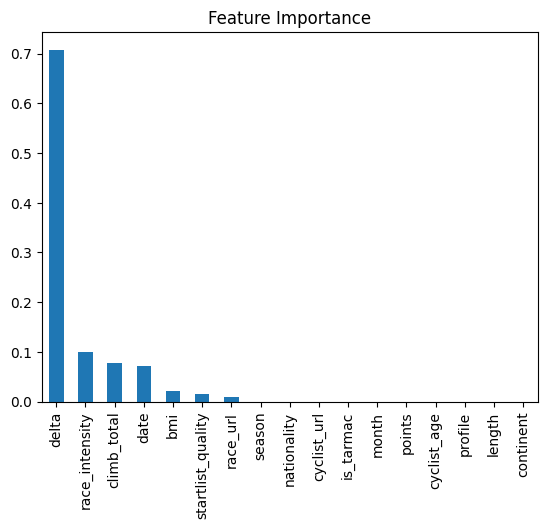

In [158]:
# Supponiamo di avere un Random Forest addestrato: dt
feature_importance = pd.Series(dt.feature_importances_, index=x_train.columns)
feature_importance = feature_importance.sort_values(ascending=False)

# Visualizzazione
feature_importance.plot(kind='bar', title="Feature Importance")
print(feature_importance)

SHAP

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from datasets import load_dataset
import pandas

from transformations import center_and_scale, drop_boolean

#noi abbiamo data_merged
train_dataset = load_dataset("mstz/adult", "income")["train"].to_pandas()
test_dataset = load_dataset("mstz/adult", "income")["test"].to_pandas()
train_labels = train_dataset["over_threshold"]
test_labels = test_dataset["over_threshold"]
train_data = train_dataset.drop("over_threshold", axis="columns", inplace=False).select_dtypes(include="number")
test_data = test_dataset.drop("over_threshold", axis="columns", inplace=False).select_dtypes(include="number")


full_dataset = pandas.concat((train_data, test_data))
_, normalization_scalers_dataset = center_and_scale(full_dataset)

# apply normalization
for feature, scaler in normalization_scalers_dataset.items():
    train_data[feature] = scaler.transform(train_dataset[feature].values.reshape(-1, 1))
    test_data[feature] = scaler.transform(test_dataset[feature].values.reshape(-1, 1))

# model
base_model = XGBClassifier()
hyperparameters = {
    "n_estimators": [25, 100, 250],
    "max_depth": [2, 3],
    "learning_rate": [1, 0.1, 0.001, 0.0001]
}
search = RandomizedSearchCV(base_model, hyperparameters, cv=5)
search.fit(train_data, train_labels)
model = search.best_estimator_
train_labels_model = model.predict(train_data)
test_labels_model = model.predict(test_data)

validation = classification_report(test_labels, test_labels_model, output_dict=True)

In [ ]:
import shap

interventional_explanation_algorithm = shap.TreeExplainer(
    model=model,
    data=train_data,                       # perturb on a causal model induced on perturbation data
    feature_perturbation="interventional"  # use a causal model
)

distributional_explanation_algorithm = shap.TreeExplainer(
    model=model,
    feature_perturbation="tree_path_dependent"  # condition on the distribution learned on the train data
)

interventional_explanations = interventional_explanation_algorithm(explanation_data)
distributional_explanations = distributional_explanation_algorithm(explanation_data)

explanations["shap_interventional"] = interventional_explanations.values
explanations["shap_distributional"] = distributional_explanations.values

shap.plots.beeswarm(interventional_explanations)

In [ ]:
shap.plots.beeswarm(distributional_explanations)

#### Rule explanation

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 20))
plot_tree(dt, feature_names=x_train.columns, class_names=['Non-Top 20', 'Top 20'], filled=True)
plt.show()

In [ ]:
from sklearn.tree import export_text
# Stampare la rappresentazione testuale dell'albero
tree_rules = export_text(dt, feature_names=list(x_train.columns))
print(tree_rules)

#### Counterfactual instances

In [ ]:
import numpy as np

# Copia dell'esempio e modifica della caratteristica 'climb_total'
modified_example = x_test.iloc[0].copy()
modified_example['climb_total'] += 500  # Aggiungi 500 metri di salita

# Fare in modo che l'input abbia la forma corretta per il modello
modified_example = np.array(modified_example).reshape(1, -1)  # Reshape per avere la forma (1, 17)

# Predizione con l'esempio modificato
modified_pred = model.predict(modified_example)
print(f"Predizione modificata: {modified_pred}")
